In [144]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import time
import datetime


## Game Logic

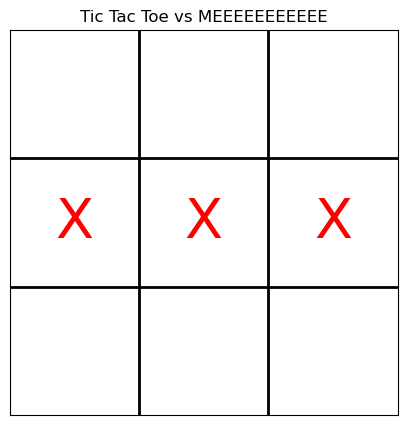

In [145]:
board = np.full((3, 3), 0 ,dtype=int)
player = 1

def make_move(board, move, player):
    row = move //3 
    col = move % 3

    if board[row, col] == 0:
        board[row, col] = player
        #print(board)
        return True
    else:
        return False
    
def convert_relative_array_to_move(board, move_array):
    # find index of move num
    choice_index = np.argmax(move_array)
    # find all empty spots and index
    empty_spots = [i for i, spot in enumerate(board.flatten()) if spot == 0]
    # return the move num with the index found first
    return empty_spots[choice_index]

def check_line(line, player):
    # Returns True if all elements in the line match the player aka X or O
    return np.all(line == player)

def check_draw(board):
    return np.all(board != 0)

def check_win(board, player):
    # Reshape
    b = board.reshape(3, 3)
    # Rows and Cols
    for i in range(3):
        if np.all(b[i, :] == player) or np.all(b[:, i] == player):
            return True
    # Diags
    if b[0,0] == b[1,1] == b[2,2] == player: return True
    if b[0,2] == b[1,1] == b[2,0] == player: return True
    return False

def available_moves(board):
    moves = []
    for i, square in enumerate(board.flatten()):
        if square == 0:
            moves.append(i)
    return moves

def draw_board(board, opponent:str):
    plt.figure(figsize=(5, 5))
    plt.xlim(0, 3)
    plt.ylim(0, 3)

    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    
    # Vertical
    plt.plot([1,1], [0,3], color='black', linewidth=2)
    plt.plot([2,2], [0,3], color='black', linewidth=2)
    # Horizontal
    plt.plot([0,3], [1,1], color='black', linewidth=2)
    plt.plot([0,3], [2,2], color='black', linewidth=2)

    #Place things
    for row in range(3):
        for col in range(3):
            symbol = board[row, col]

            if symbol != 0:
                x_pos = col + 0.5
                y_pos = 2.5 - row
                #Color
                color = 'red' if symbol == 1 else 'blue'
                #draw
                plt.text(x_pos, y_pos,'X' if symbol == 1 else 'O', fontsize=40, ha='center', va='center', color=color)
    plt.title("Tic Tac Toe vs " + opponent)
    plt.show()


make_move(board, 3, 1)
make_move(board, 4, 1)
make_move(board, 5, 1)
available_moves(board)
check_win(board, 1)
draw_board(board, "MEEEEEEEEEEE")
# print(check_win(board))
# print(check_draw(board))
# #clear_board()

# # while True:
# #     input()

## Policy things

In [146]:
#Load perfect strategy
perfect_strategy = pickle.load(open("perfectPolicy.p", "rb"))
print(len(perfect_strategy))
print(perfect_strategy)
type(perfect_strategy[(0,0,0,0,0,0,0,0,0)])

4520
{(0, 0, 0, 0, 0, 0, 0, 0, 0): array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), (1, 0, 0, 0, 0, 0, 0, 0, 0): array([0., 0., 0., 1., 0., 0., 0., 0.]), (1, 2, 0, 0, 0, 0, 0, 0, 0): array([0., 0., 1., 0., 0., 0., 0.]), (1, 2, 1, 0, 0, 0, 0, 0, 0): array([0., 1., 0., 0., 0., 0.]), (1, 2, 1, 2, 0, 0, 0, 0, 0): array([1., 0., 0., 0., 0.]), (1, 2, 1, 2, 1, 0, 0, 0, 0): array([1., 0., 0., 0.]), (1, 2, 1, 2, 1, 2, 0, 0, 0): array([1., 0., 0.]), (1, 2, 1, 2, 1, 2, 0, 1, 0): array([1., 0.]), (1, 2, 1, 2, 1, 2, 2, 1, 0): array([1.]), (1, 2, 1, 2, 1, 2, 0, 1, 2): array([1.]), (1, 2, 1, 2, 1, 0, 2, 0, 0): array([0., 0., 1.]), (1, 2, 1, 2, 1, 1, 2, 0, 0): array([0., 1.]), (1, 2, 1, 2, 1, 1, 2, 2, 0): array([1.]), (1, 2, 1, 2, 1, 1, 2, 0, 2): array([1.]), (1, 2, 1, 2, 1, 0, 2, 1, 0): array([0., 1.]), (1, 2, 1, 2, 1, 0, 2, 1, 2): array([1.]), (1, 2, 1, 2, 1, 0, 0, 2, 0): array([1., 0., 0.]), (1, 2, 1, 2, 1, 1, 0, 2, 0): array([1., 0.]), (1, 2, 1, 2, 1, 1, 0, 2, 2): array([1.]), (1, 2, 1, 2, 1, 0, 0, 0,

numpy.ndarray

## Agent

In [147]:
class QAgent:
    def __init__(self, symbol, epsilon=0.8, gamma=0.9, alpha=0.1, epsilon_min=0.01, decay_rate=0.99995):
        self.symbol = symbol
        self.q_table = {}
        # Epsilon decay
        self.epsilon = epsilon # Chansen att agenten gör ett slumpmässigt drag 
        self.epsilon_min = epsilon_min
        self.decay_rate = decay_rate

        self.gamma = gamma # Hur mycket framtida belöningar värderas jämfört med omedelbara.
        self.alpha = alpha # Inlärningshastighet
        self.last_state = None
        self.last_action = None

        self.game_history = []

    def get_state_string(self, board):
        return str(board.reshape(9)) # gör om numpy array till en string för användan i dict

    def decay_epsilon(self):
        # reduce epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.decay_rate

    def choose_move(self, board, train=True):
        state = self.get_state_string(board)
        moves = available_moves(board)

        #epsilon random exploration thing
        if random.random() < self.epsilon and train:
            return random.choice(moves)
        
        # utvärdera vilket drag man ska gör utifrån q tabellen

        # lägger alla drag som går att göra tillsamans med q värdet i en tupel och sedan lägger tupeln i en lista
        moves_with_q_value = []
        max_q = -float('inf')
        for m in moves:
            q_val = self.q_table.get((state, m), 0.0)
            moves_with_q_value.append((m, q_val))
            if q_val > max_q:
                max_q = q_val
        
        #filtrerar ut dom bästa dragen baserat på q värde
        best_moves = []
        for m in moves_with_q_value:
            if m[1] == max_q:
                best_moves.append(m)
        #väljer en slumpmässig move bland de bästa
        action = random.choice(best_moves)[0]

        if train:
            self.last_state = state
            self.last_action = action
        return action
    
    def record_move(self, board, move):
        self.game_history.append((self.get_state_string(board), move))
        
    def update_q_table(self, reward):
        #uppdatera q tabelen baserat på matchen
        
        current_reward = reward

        # går igenom dragen baklänges
        for state, move in reversed(self.game_history):
            current_q = self.q_table.get((state, move), 0.0)

            new_q = current_q + self.alpha * (current_reward - current_q)
            self.q_table[(state, move)] = new_q

            # gör belöningen mindre för varje steg bakåt
            current_reward *= self.gamma
        
        #rensar för nästa spel
        self.game_history = []
        

    def save_agent(self, filename="q_agent_policy.pkl"):
        """Saves the trained agent to a file."""
        with open(filename, "wb") as f:
            pickle.dump(self.q_table, f)
        print(f"Agent saved to {filename}")

    def load_agent(self, filename="q_agent_policy.pkl"):
        """Loads a trained agent from a file."""
        try:
            with open(filename, "rb") as f:
                agent = pickle.load(f)
            print(f"Agent loaded from {filename}")
            self.q_table = agent
        except FileNotFoundError:
            print(f"Error: File '{filename}' not found.")

            
        


## Traning

In [148]:
def train_agent(episodes=10000, perfect_policy=perfect_strategy):
    # Agent plays as 1
    qa1 = QAgent(symbol=1) 
    qa2 = QAgent(symbol=2) 

    print("Training started...")
    score_vs_perfect = {}
    score_vs_random = {}

    start_time = time.perf_counter()

    for i in range(1, episodes + 1):

        # Reset Game
        board = np.full((3, 3), 0, dtype=int)
        game_over = False
        current_player = qa1
        other_player = qa2

        # Game Loop
        while not game_over:
            # select move
            move = current_player.choose_move(board)

            # save move
            current_player.record_move(board, move)

            # play move
            make_move(board, move, current_player.symbol)

            # check game status
            if check_win(board, current_player.symbol):
                current_player.update_q_table(reward=1)
                other_player.update_q_table(reward=-1)
                game_over = True
            elif check_draw(board):
                current_player.update_q_table(reward=0.2)
                other_player.update_q_table(reward=0.2)
                game_over = True

            # agents switch place
            current_player, other_player = other_player, current_player
            
        qa1.decay_epsilon()
        qa1.decay_epsilon()

        if i == 1:
            random_score, perfect_score = play_evaluation_games(qa1, perfect_policy, 100)
            score_vs_perfect[i] = perfect_score
            score_vs_random[i] = random_score

        if i % 500 == 0:
            # Run eval games
            random_score, perfect_score = play_evaluation_games(qa1, perfect_policy, 100)
            score_vs_perfect[i] = perfect_score
            score_vs_random[i] = random_score

        if i % 5000 == 0:
            # calc time
            current_time = time.perf_counter()
            elapsed_time = current_time - start_time
            
            # Average time per episode so far
            avg_time_per_episode = elapsed_time / i
            
            # Calculate remaining
            remaining_episodes = episodes - i
            time_left = remaining_episodes * avg_time_per_episode
            
            # Format (HH:MM:SS)
            elapsed_str = str(datetime.timedelta(seconds=int(elapsed_time)))
            remaining_str = str(datetime.timedelta(seconds=int(time_left)))

            print(f"Episode {i}/{episodes} | Elapsed: {elapsed_str} | Remaining: {remaining_str}")


    print(f"Training Done.")

    #display graph thing
    plot_data(score_vs_perfect, "Score vs Perfect")
    plot_data(score_vs_random, "Score vs Random")

    return qa1

def plot_data(data, titel):
    indices = sorted(data.keys())
    wins = [data[i][0] for i in indices]
    draws = [data[i][1] for i in indices]
    losses = [data[i][2] for i in indices]

    plt.figure(figsize=(10, 6))

    plt.plot(indices, wins, label='Wins', color='green', marker='o')
    plt.plot(indices, draws, label='Draws', color='blue', marker='o')
    plt.plot(indices, losses, label='Losses', color='red', marker='o')

    plt.title(titel)
    plt.xlabel("Episodes (Index)")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)

    plt.show()


def play_evaluation_games(agent, perfect_policy, game_count):
    win = 0
    draw = 0
    loss = 0
    
    win, draw, loss = 0, 0, 0
    
    for i in range(game_count):
        board = np.full((3, 3), 0, dtype=int)
        game_over = False
        
        while not game_over:
            # Agent Move 
            move = agent.choose_move(board, train=False)
            make_move(board, move, 1)

            if check_win(board, 1):
                win += 1
                game_over = True
                continue
            if check_draw(board):
                draw += 1
                game_over = True
                continue
            
            # Random Move 
            opp_moves = available_moves(board)
            opp_move = random.choice(opp_moves)
            make_move(board, opp_move, 2)

            if check_win(board, 2):
                loss += 1
                game_over = True
                continue
            if check_draw(board):
                draw += 1
                game_over = True
                continue
                
    random_score = (win, draw, loss)

    win, draw, loss = 0, 0, 0
    
    for i in range(game_count):
        board = np.full((3, 3), 0, dtype=int)
        game_over = False
        
        while not game_over:
            # Agent Move
            move = agent.choose_move(board, train=False)
            make_move(board, move, 1)

            if check_win(board, 1):
                #print("win 1")
                win += 1
                game_over = True
                continue
            if check_draw(board):
                #print("draw")
                draw += 1
                game_over = True
                continue

            state_tuple = tuple(board.reshape(9))
            #print(state_tuple)
            #print(board)
            opp_move = convert_relative_array_to_move(board, perfect_policy[state_tuple])
            make_move(board, opp_move, 2)

            if check_win(board, 2):
                #print("win 2")
                loss += 1
                game_over = True
                continue
            if check_draw(board):
                #print("draw 2")
                draw += 1
                game_over = True
                continue

    perfect_score = (win, draw, loss)
    # print("perfect score")
    # print(perfect_score)

    return random_score, perfect_score

# --- EXECUTION ---
trained_agent = train_agent(5000000)
# agent1 = QAgent(symbol=1, epsilon=0.1) 
# play_evaluation_games(agent1, 1)

Training started...
Episode 5000/50000000 | Elapsed: 0:00:02 | Remaining: 7:15:56
Episode 10000/50000000 | Elapsed: 0:00:05 | Remaining: 7:06:43
Episode 15000/50000000 | Elapsed: 0:00:07 | Remaining: 6:58:39
Episode 20000/50000000 | Elapsed: 0:00:09 | Remaining: 6:52:55
Episode 25000/50000000 | Elapsed: 0:00:12 | Remaining: 6:46:49
Episode 30000/50000000 | Elapsed: 0:00:14 | Remaining: 6:45:33
Episode 35000/50000000 | Elapsed: 0:00:17 | Remaining: 6:44:28
Episode 40000/50000000 | Elapsed: 0:00:19 | Remaining: 6:42:44
Episode 45000/50000000 | Elapsed: 0:00:21 | Remaining: 6:40:53
Episode 50000/50000000 | Elapsed: 0:00:24 | Remaining: 6:40:01


KeyboardInterrupt: 

## Game Player

In [ ]:
def input_processor(move):
    move = move.split(' ')
    
    x = int(move[0])
    y = int(move[1])
    return (x,y)


opponent = "Human"
#choice = input("1 = Human. 2 = Random. 3 = Perfect Policy. 4 = Home Grown Policy 5 = Dont play")
choice = "5"
run_game = True
if choice == "5":
    run_game = False
while run_game:
    
    #First Player
    player = 1
    if choice == "1":
        opponent = "Human"
        make_move(board, input_processor(input("X players turn (input like this:1 2)")))
        draw_board(board, opponent)
        if check_win(board):
            run_game = False
            print("X player win")
            clear_board()
            continue
        if check_draw(board):
            run_game = False
            print("Draw")
            clear_board()
            continue
    elif choice == "2":
        opponent = "RNGesus"
        valid_play = False
        while not valid_play:
            x = random.randint(0, 2)
            y = random.randint(0, 2)
            if board[y][x] == 0:
                valid_play = True
                make_move(board, (x,y))
                draw_board(board, opponent)
                
        if check_win(board):
            run_game = False
            print("X player win")
            clear_board()
            continue            
        if check_draw(board):                
            run_game = False
            print("Draw")
            clear_board()
            continue

    
    #Second Player
    player = 2
    make_move(board, input_processor(input("O players turn (input like this:1 2)")))
    draw_board(board, opponent)
    if check_win(board):
        run_game = False
        print("O player win")
        clear_board()
    if check_draw(board):
        run_game = False
        print("Draw")
        clear_board()
        

